## Blockchain Research: Oracle Attack
### Catherine Gu wcgu@stanford.edu, Stanford University

In [1]:
import json
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
import plotly.plotly as py
import plotly.graph_objs as go
from tqdm import tqdm
from functools import reduce
import scipy.stats as sts

In [2]:
cwd = os.getcwd()

In [3]:
def error_check(j):
    timeStamp = [int(each['timeStamp'],16) for each in j]
    block = [int(each['blockNumber'],16) for each in j]
    count = 0
    count_error = 0
    for each in j:
        if len(each['topics']) == 4:
            count += 1
        else:
            count_error += 1
    print(count, count_error)

    
def check_boolean_is_false(j):
    count = 0
    for each in j:
        timeStamp = int(each['timeStamp'],16)
        if len(each['topics']) == 4:
            zzz = int(each['topics'][3][-8:],16)
            if timeStamp > zzz:
                count += 1
    print(count)

In [4]:
files = []
cwd = os.getcwd()
for i in range(14):
    filename = str(cwd + '/' + str(i+1) + '/out')
    j = json.load(open(filename))['result']
#     print("How many booleans return False, i.e. now > zzz"), check_boolean_is_false(j)
#     print("No of price reported, number of price not reported"), print(len(j)), error_check(j)

In [5]:
def get_number(feeder):
    list_0_3 = ['14']
    list_0_4 = ['3', '4', '5', '10', '11', '13']
    list_0_5 = ['1', '2', '7',]
    list_0_6 = ['9', '12']
    list_0_7 = ['8']
    list_0_8 = ['6']
    if feeder in list_0_3:
        return 4;
    if feeder in list_0_4:
        return 5;
    if feeder in list_0_5:
        return 6;
    if feeder in list_0_6:
        return 7;
    if feeder in list_0_7:
        return 8;
    if feeder in list_0_8:
        return 9;
    return 0

In [6]:
def create_dataframe(feeder, apifile):
    j = json.load(open(apifile))['result']
    timeStamp = []
    block = []
    prices = []
    expire = []
    for each in j:
        if len(each['topics']) == 4:
            each_block = int(each['blockNumber'],16)
            each_timeStamp = datetime.fromtimestamp(int(each['timeStamp'],16))
            zzz = datetime.fromtimestamp(int(each['topics'][3][-8:],16))

            if each_timeStamp < zzz:
                each_expire = zzz - each_timeStamp
                expire.append(each_expire.seconds / 3600) #convert to diff in hours
                timeStamp.append(each_timeStamp)
                block.append(each_block)
                prices.append(int(each['topics'][2],16))
    df = pd.DataFrame(list(zip(block, timeStamp,prices, expire)), 
               columns =['blockNumber_' + feeder, 'timeStamp','Feeder_'+ feeder, 'Expire_'+ feeder]) 
#     df = df.set_index('blockNumber')
    df['Feeder_'+ feeder] = df['Feeder_'+ feeder].apply(lambda x: x / 10e17)
    df = df[df!=0]
    return df

In [7]:
def populate(feeder, number):
    df_list = []
    for n in reversed(range(number)):
        apifile = str(cwd + '/' + feeder + '/api' + str(n))
        sub = create_dataframe(feeder, apifile)
        df_list.append(sub)
    df = df_list[0]
    for x in range(1, len(df_list)):
        df = df.append(df_list[x])
    df = df.drop_duplicates()
    df.sort_values(by = ['timeStamp'], ascending = True, inplace = True)
    return df

In [8]:
fs = np.arange(1,15)
files = []
for f in fs:
    n = get_number(str(f))
    df = populate(str(f), n)
    files.append(df)

### Creating dfs_raw: No Forward Fill

In [9]:
dfs_raw = files[0].merge(files[1], how = 'outer', sort = True)
for i in range(2,14):
    dfs_raw = dfs_raw.merge(files[i], how = 'outer', sort = True)
    
for i in range(1,15):
    dfs_raw['Expire_'+str(i)] = dfs_raw['Expire_'+str(i)].round(0)

dfs_raw['timeStamp'] = dfs_raw.timeStamp.apply(lambda x: x.replace(second = 0, minute = 0) + timedelta(hours = 1))
dfs_raw = dfs_raw.groupby('timeStamp').last()

In [10]:
myrange = dfs_raw.loc['2019-05-18 00:00:00':'2019-09-17 15:00:00'].index
dfs_raw = dfs_raw.drop(index = myrange)
dfs_raw.tail()

,blockNumber_1,Feeder_1,Expire_1,blockNumber_2,Feeder_2,Expire_2,blockNumber_3,Feeder_3,Expire_3,blockNumber_4,...,Expire_11,blockNumber_12,Feeder_12,Expire_12,blockNumber_13,Feeder_13,Expire_13,blockNumber_14,Feeder_14,Expire_14
timeStamp,,,,,,,,,,,,,,,,,,,,,
2019-05-17 19:00:00,7781283.0,239.04,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-17 20:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7781371.0,241.090,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-17 21:00:00,7781742.0,244.14,12.0,NaN,NaN,NaN,7781724.0,243.585,12.0,NaN,...,12.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-17 22:00:00,NaN,NaN,NaN,NaN,NaN,NaN,7782164.0,243.460,12.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-05-17 23:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating dfs_ff: Forward Fill by Age

In [11]:
dfs_ff = dfs_raw.copy(deep = True)

In [12]:
def can_forward_fill_next(current_row, feeder, raw_data):
    current_price_value = raw_data.iloc[current_row]["Feeder_" + str(feeder)]
    next_price_value = raw_data.iloc[current_row + 1]["Feeder_" + str(feeder)]
    current_price_age = raw_data.iloc[current_row]["Expire_" + str(feeder)]
    if np.isnan(current_price_value) == False and np.isnan(next_price_value) == True:
        #Maker's condition where bool = True if now < zzz 
        if current_price_age > 0:
            return True
        else: 
            return False
    return False

In [13]:
for row in range(0,len(dfs_ff.index) - 1):
    for i in range(1,15):
        if can_forward_fill_next(row, i, dfs_ff):
            #forward fill next row value using current row value
            dfs_ff.iloc[row + 1]["Feeder_"+str(i)] = dfs_ff.iloc[row]["Feeder_"+str(i)] 
            #decrement expiry by one hour
            dfs_ff.iloc[row + 1]["Expire_"+str(i)] = dfs_ff.iloc[row]["Expire_"+str(i)] - 1

'''
Note there might be some edge cases when Age is between 1 and 0: since we rounded to the hour
so sometimes when in reality Medianizer may not include a price in its computation we would, 
as are rounded to the nearest hour. E.g.: dfs_ff.iloc[990:1020]
'''

'\nNote there might be some edge cases when Age is between 1 and 0: since we rounded to the hour\nso sometimes when in reality Medianizer may not include a price in its computation we would, \nas are rounded to the nearest hour. E.g.: dfs_ff.iloc[990:1020]\n'

In [14]:
df_main = dfs_ff.copy(deep = True)
df_main = df_main.reset_index()

In [16]:
def extract_dataframe(df, feeder):
    result = df.loc[:, ["timeStamp", "blockNumber_" + str(feeder), "Feeder_" + str(feeder), "Expire_" + str(feeder)]]
    return result

In [17]:
datastore = []
for i in range(14):
    f = extract_dataframe(df_main, i+1)
    expired = f['Expire_' + str(i+1)].isin(['0'])
    f['blockNumber_'+str(i+1)] = f[~expired]['blockNumber_'+str(i+1)].ffill()
    result = f.merge(files[i], how = 'left', left_on='blockNumber_'+str(i+1), right_on='blockNumber_'+str(i+1))
    result.drop(columns = ['Feeder_'+str(i+1)+'_y','Expire_'+str(i+1)+'_y'])
    result['Age_'+str(i+1)] = (result.timeStamp_x - result.timeStamp_y).dt.components.hours
    result = result.set_index('timeStamp_x')
    datastore.append(result)

In [18]:
df_Age = pd.DataFrame(index = datastore[0].index)
for i in range(14):
    df_Age["Feeder_"+str(i+1)] = datastore[i]['Age_'+str(i+1)]

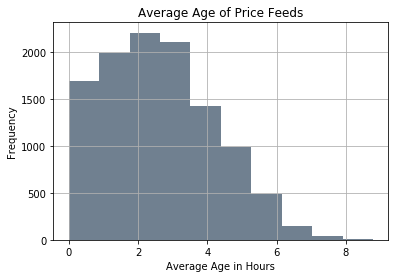

In [19]:
analyzer = pd.DataFrame(index = df_Age.index)
analyzer['Average_age'] = np.mean(df_Age.loc[:,"Feeder_1":"Feeder_14"],axis = 1)
analyzer.Average_age.hist(color = 'slategrey')
plt.ylabel("Frequency")
plt.xlabel('Average Age in Hours')
plt.title("Average Age of Price Feeds")
plt.savefig("Average Age of Price Feeds")

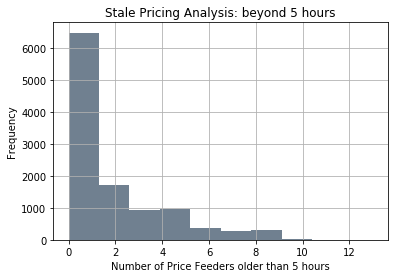

In [22]:
hour = 5
analyzer['>' + str(hour)] = df_Age.gt(hour).sum(axis = 1)
analyzer['>' + str(hour)].hist(color = 'slategrey')
plt.ylabel("Frequency")
plt.xlabel("Number of Price Feeders older than " + str(hour) + " hours")
plt.title("Stale Pricing Analysis: beyond " + str(hour) + " hours")
plt.show()

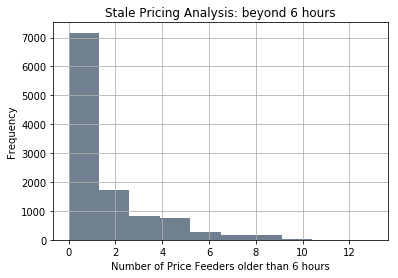

In [25]:
hour = 6
analyzer['>' + str(hour)] = df_Age.gt(hour).sum(axis = 1)
analyzer['>' + str(hour)].hist(color = 'slategrey')
plt.ylabel("Frequency")
plt.xlabel("Number of Price Feeders older than " + str(hour) + " hours")
plt.title("Stale Pricing Analysis: beyond " + str(hour) + " hours")
plt.savefig("Stale Pricing Analysis: beyond " + str(hour) + " hours")